In [17]:
import numpy as np
import deepxde as dde
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from functools import partial
from math import sin

In [18]:
save_folder = "./visualization/"
dde.config.set_default_float("float64")
origin_ns = np.array([[1, 1], [1, 2], [2, 1], [2, 2]])

Set the default float type to float64


In [19]:
def plot_2d(x, y, solution, title):
    plt.scatter(x, y, c=solution, cmap='viridis')
    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    # Add a colorbar
    plt.colorbar()
    # Show the plot
    plt.show()
    plt.savefig(save_folder + title)
    plt.close()

def contour_plot(X, Y, Z, title):
    plt.style.use('_mpl-gallery-nogrid')
    levels = np.linspace(np.min(Z), np.max(Z), 25)
    # plot
    fig, ax = plt.subplots()
    ax.plot(X, Y, 'o', markersize=2, color='lightgrey')
    ax.tricontour(X, Y, Z, levels=levels)

    ax.set(xlim=(-3, 3), ylim=(-3, 3))

    plt.show()
    plt.savefig(save_folder + title)
    plt.close()

In [20]:
def exact_sol(f,n1,n2):
    # ns = origin_ns
    x = f[:, 0:1]
    y = f[:, 1:2]
    return np.sin(n1*np.pi*(x + 1)*0.5)*np.sin(n2*np.pi*(y + 1)*0.5)

def exact2(f,n1,n2):
    arr = []
    for x,y in f:
        tmp = sin(n1*np.pi*(x + 1)*0.5)*sin(n2*np.pi*(y + 1)*0.5)
        arr.append(tmp)
    return np.array(arr)


In [21]:
def pde(netw_in, netw_out, n1, n2):
    dy_xx = dde.grad.hessian(netw_out, netw_in, i=0, j=0)
    dy_yy = dde.grad.hessian(netw_out, netw_in, i=1, j=1)
    return 0.5*(dy_xx + dy_yy)+(n1**2+n2**2)*(np.pi**2)*netw_out/8


def boundary(_, on_boundary):
    return on_boundary

In [22]:
def generate_test_data(size):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    test_x, test_y = np.meshgrid(x, y)
    test_x = test_x.reshape(-1)
    test_y = test_y.reshape(-1)
    return np.vstack((test_x, test_y)).T
    

def get_solution(data,model):
    solution = np.hstack([model.predict(el) for el in data])
    return solution

def graph_shreodinger(x,y,z,title,fig,ax,i,j):
    fig.set_size_inches(10, 10)
    fig.suptitle(title)
    contour = ax[i][j].tricontour(x, y, z)
    ax[i][j].clabel(contour, inline=1, fontsize=10)

def initial_points(points, values):
    tps = []
    for i in range(len(points)):
        tp = dde.PointSetBC(points[i], values[i])
        tps.append(tp)
    return tps

def get_value(points,n1,n2):
    tmp1 = np.sin(n1 * np.pi * (points[:, :, 0] + 1) / 2)
    tmp2 = np.sin(n2 * np.pi * (points[:, :, 1] + 1 ) / 2)
    res = tmp1 * tmp2
    return res.reshape(1, -1)[0]

Compiling model...
'compile' took 0.000569 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric   
0         [4.66e-02, 1.06e-01, 4.54e-01, 1.61e-01, 3.58e-01, 1.00e+00]    [4.66e-02, 1.06e-01, 4.54e-01, 1.61e-01, 3.58e-01, 1.00e+00]    [1.05e+00]    
1000      [5.47e-04, 7.05e-06, 6.43e-05, 4.52e-05, 1.33e-05, 8.27e-05]    [5.47e-04, 7.05e-06, 6.43e-05, 4.52e-05, 1.33e-05, 8.27e-05]    [5.81e-02]    
2000      [1.39e-04, 5.00e-11, 1.87e-07, 5.33e-08, 5.00e-09, 5.39e-08]    [1.39e-04, 5.00e-11, 1.87e-07, 5.33e-08, 5.00e-09, 5.39e-08]    [5.75e-02]    

Best model at step 2000:
  train loss: 1.39e-04
  test loss: 1.39e-04
  test metric: [5.75e-02]

'train' took 22.625729 s



ValueError: not enough values to unpack (expected 2, got 1)

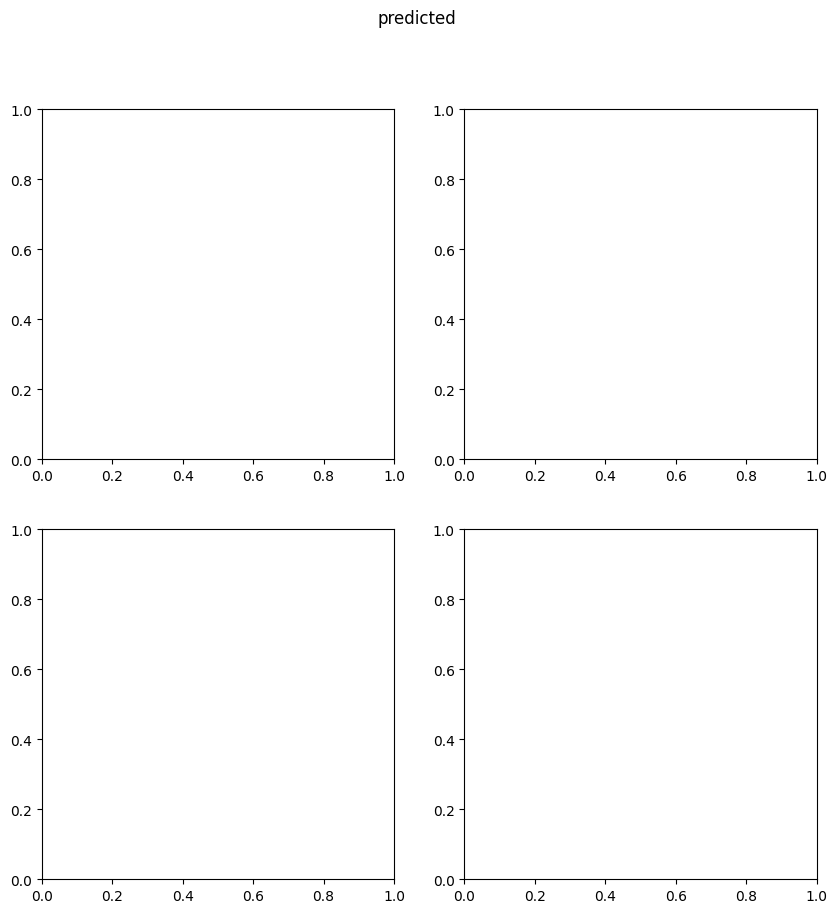

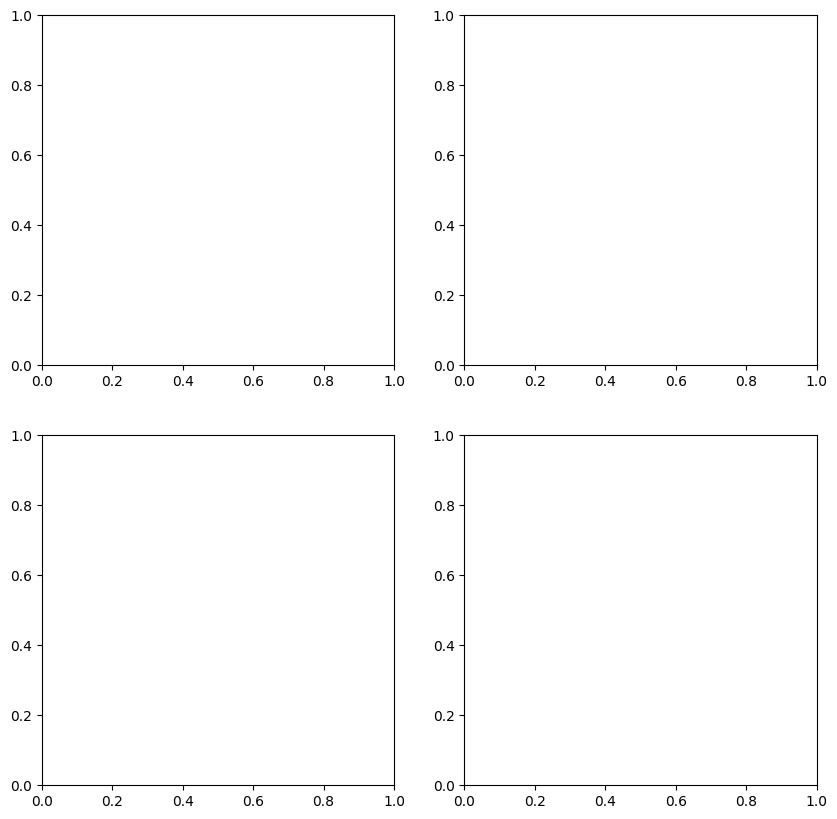

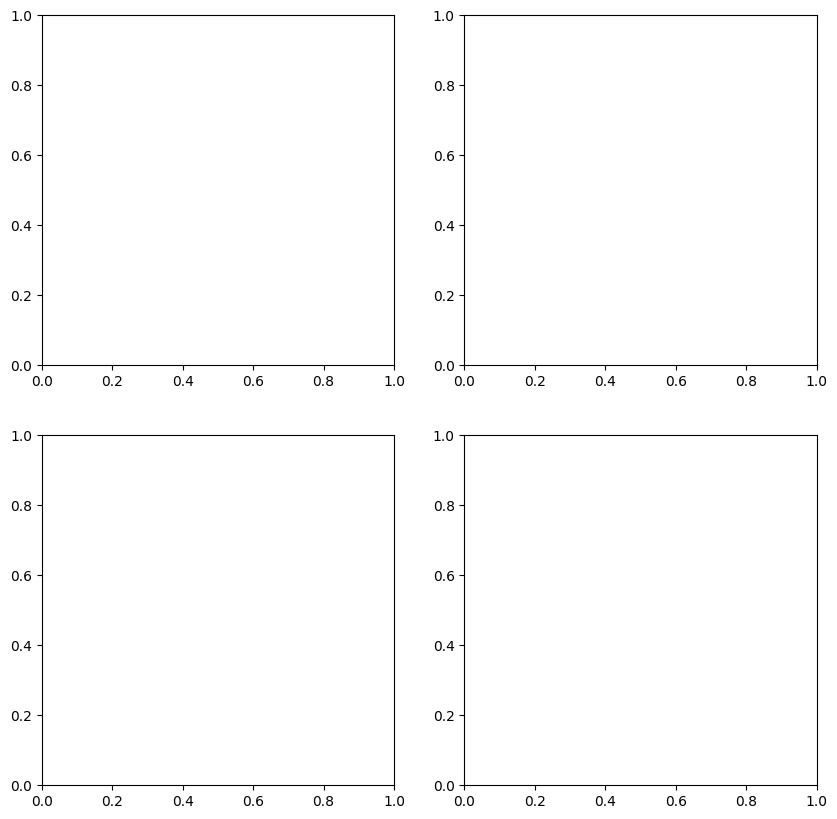

In [23]:
geom = dde.geometry.Rectangle([-1, -1], [1, 1])
bc = dde.icbc.DirichletBC(geom, lambda x: 0, lambda x, on_boundary: on_boundary)
fig_p, ax_p = plt.subplots(nrows=2, ncols=2)
fig_p.set_size_inches(10, 10)
fig_e, ax_e = plt.subplots(nrows=2, ncols=2)
fig_e.set_size_inches(10, 10)
fig_r, ax_r = plt.subplots(nrows=2, ncols=2)
fig_r.set_size_inches(10, 10)
for i, ns in enumerate(origin_ns):
    conditions = [bc]
    new_pde = partial(pde,n1=ns[0],n2=[ns[1]])
    certain = np.array([[[-0.5, 0.5]], [[0.5, -0.5]],[[-0.5, -0.5]],[[0.5, 0.5]],[[0, 0]]])
    values = get_value(certain, ns[0],ns[1])
    constr = initial_points(certain, values)
    conditions.extend(constr)
    exn = partial(exact_sol,n1=ns[0],n2=ns[1])
    data = dde.data.PDE(
        geom, 
        new_pde, 
        conditions, 
        num_domain = 800,
        num_boundary = 100,
        num_test=10**3,
        solution=exn,
    )
    layer_size = [2] + [20] * 3 + [1]
    activation = "tanh"
    initializer = "Glorot normal"

    net = dde.maps.FNN(layer_size, activation, initializer)


    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])

    losshistory, train_state = model.train(iterations=2000)
    test_domain = generate_test_data(100)
    predicted_solution = get_solution(test_domain,model)
    graph_shreodinger(test_domain[:,0],test_domain[:,1],predicted_solution,"predicted",fig_p,ax_p,i%2,i//2)
    exact_solution = exact2(test_domain,ns[0],ns[1])
    graph_shreodinger(test_domain[:,0],test_domain[:,1],exact_solution,"exact",fig_e,ax_e,i%2,i//2)
    error_l2 = (np.abs(predicted_solution - exact_solution)/exact_solution)**2
    for j in range(len(error_l2)):
        if error_l2[j]==float('inf'):
            error_l2[j] = 0.0 
    print(error_l2)
    graph_shreodinger(test_domain[:,0],test_domain[:,1],error_l2,"exact",fig_r,ax_r,i%2,i//2)